This jupyter notebook conducts experiments to see what are the best parameters and filters to use to shrink the transaction graph.
Some parameters to consider:
1. The timesteps on which we decide which the wallets to keep
2. The number of transactions conducted by each wallet
3. The connectivity of wallet
4. The amount of ethereum transacted from/to the wallet

# 1. Get a basic sense: check graph size of one time step

In [1]:
from graph_tools.components.graph import TransactionGraph, GraphGenerator

In [4]:
short_period_graph = TransactionGraph(transaction_file='data/raw/transaction table 20190101-20190401.csv', total_time_steps=10)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]


In [5]:
# Check the number of involve wallets/transactions in each time step
for t, g in short_period_graph.time_series_graph.items():
    print(f"At time step {t}: {len(g.nodes)} nodes; {len(g.edges)} edges")

At time step 29119: 512 nodes; 396 edges
At time step 29120: 1583 nodes; 1605 edges
At time step 29121: 1549 nodes; 1478 edges
At time step 29122: 2214 nodes; 2196 edges
At time step 29123: 2118 nodes; 2090 edges
At time step 29124: 2159 nodes; 2135 edges
At time step 29125: 2003 nodes; 2050 edges
At time step 29126: 2246 nodes; 2312 edges
At time step 29127: 2455 nodes; 2608 edges
At time step 29128: 2901 nodes; 3037 edges


In [14]:
# skip the first time step, since it does not contain a full 1 hour
# check how many nodes are shared among the 10 time steps
nine_graphs = []
for t, g in short_period_graph.time_series_graph.items():
    if t == 29119:
        continue
        
    nine_graphs.append(g)
    
nodes = [set(g.nodes.keys()) for g in nine_graphs]

In [22]:
all_nodes = set()
for node_set in nodes:
    all_nodes = all_nodes.union(node_set)
    
print("number of unique nodes in first 9 time steps")
print(len(all_nodes))

number of unique nodes in first 9 time steps
13785


In [23]:
shared_nodes = set(all_nodes)
for node_set in nodes:
    shared_nodes = shared_nodes.intersection(node_set)

print("number of shared nodes in first 9 time steps")
print(len(shared_nodes))

number of shared nodes in first 9 time steps
78


In [25]:
generator = GraphGenerator('data/raw/transaction table 20190101-20190401.csv')

print("number of unique nodes in first 3 months")
print(len(generator.wallet_frequency))

number of unique nodes in first 3 months
1757710


In [30]:
more_than_2 = list(filter(lambda t: t[0] > 1, generator.wallet_frequency))

print("number of unique nodes that have at least 2 operations")
print(len(more_than_2))

number of unique nodes that have at least 2 operations
1470117


In [31]:
more_than_3 = list(filter(lambda t: t[0] > 2, generator.wallet_frequency))

print("number of unique nodes that have at least 3 operations")
print(len(more_than_3))

number of unique nodes that have at least 3 operations
485171


In [32]:
more_than_10 = list(filter(lambda t: t[0] > 9, generator.wallet_frequency))

print("number of unique nodes that have at least 10 operations")
print(len(more_than_10))

number of unique nodes that have at least 10 operations
108870


# 2. Try shrink the file to a toy-env fist: at least 10 transactions are required

In [34]:
from graph_tools.data_utils.shrink_graph import shrink_by_least_transaction

shrink_by_least_transaction("./data/raw/transaction table 20190101-20190401.csv",
                            "./data/shrunk/transaction-table-at_least_10-20190101-20190401.csv",
                            10)

In [35]:
generator = GraphGenerator('data/shrunk/transaction-table-at_least_10-20190101-20190401.csv')

print("number of unique nodes in first 3 months")
print(len(generator.wallet_frequency))

number of unique nodes in first 3 months
1487677


In [1]:
from graph_tools.data_utils.shrink_graph import shrink_by_least_transaction

shrink_by_least_transaction("./data/raw/transaction table 20190101-20190401.csv",
                            "./data/shrunk/transaction-table-at_least_10_both-20190101-20190401.csv",
                            10, True)

In [4]:
generator = GraphGenerator('data/shrunk/transaction-table-at_least_10_both-20190101-20190401.csv')


print("number of unique nodes in first 3 months, both with at least 10 transactions")
print(len(generator.wallet_frequency))

number of unique nodes in first 3 months, both with at least 10 transactions
107307


Shrinking by at least 10 transactions in the first 3 months, requiring it on both ends work nicely

# 3. Shrunk data overview

In [3]:
from graph_tools.components.graph import GraphGenerator, TransactionGraph

In [4]:
print("How many transactions do these nodes involve in the original graph?")

generator = GraphGenerator('data/shrunk/transaction-table-at_least_10_both-20190101-20190401.csv')
kept_wallets = set(map(lambda f2w: f2w[1], generator.wallet_frequency))

generator_original = GraphGenerator('data/raw/transaction table 20190101-20190401.csv')
original_freqs = list(filter(lambda f2w: f2w[1] in kept_wallets, generator_original.wallet_frequency))

How many transactions do these nodes involve in the original graph?


In [19]:
freqs = list(map(lambda f2a: f2a[0], list(original_freqs)))

print(f"min {min(freqs)}; max {max(freqs)}")

min 10; max 324333


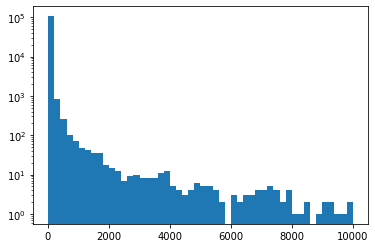

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(freqs, range=[10, 10000], log=True, bins=50)
plt.show()

In [32]:
g = TransactionGraph(transaction_file='./data/shrunk/transaction-table-at_least_10_both-20190101-20190401.csv',
                     total_time_steps=10)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


In [38]:
g.time_series_graph.keys()

dict_keys([29119, 29120, 29121, 29122, 29123, 29124, 29125, 29126, 29127, 29128])

In [36]:
import networkx.drawing.nx_pylab as nx

628
634


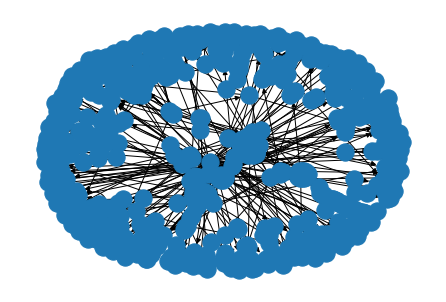

In [41]:
print(len(g.time_series_graph[29120].nodes))
print(len(g.time_series_graph[29120].edges))
nx.draw(g.time_series_graph[29120])
plt.draw()

## 4. connect with price data

In [20]:
from dateutil import parser
from datetime import datetime
timestep_to_stamp = dict()
with open('../../data/time_step_to_time_stamp.csv', 'r') as reader:
    for i, line in enumerate(reader):
        if i == 0:
            continue
        
        step, min_time, max_time = line.strip().split(',')
        
        timestep_to_stamp[int(step)] = (datetime.timestamp(parser.parse(min_time)),
                                        datetime.timestamp(parser.parse(max_time)))

In [21]:
timestamp_to_price = dict()
with open('../../data/ETHUSD_1hr.csv', 'r') as reader:
    for i, line in enumerate(reader):
        if i == 0:
            continue
            
        time, price = line.split(',')[0], line.split(',')[-1]
        
        timestamp_to_price[datetime.timestamp(parser.parse(time))] = float(price)

In [24]:
from datetime import datetime
timestep_to_price = dict()

for timestep, (min_time, max_time) in timestep_to_stamp.items():
    avg_time = (min_time + max_time) / 2
    right_below_time = 0
    right_below_price = 0
    for candidate_time, price in timestamp_to_price.items():
        if candidate_time <= avg_time \
            and candidate_time > right_below_time:
            right_below_time = candidate_time
            right_below_price = price
            
    timestep_to_price[timestep] = (right_below_price, right_below_time)

In [25]:
timestep_to_price

{29119: (0, 0),
 29120: (0, 0),
 29121: (0, 0),
 29122: (0, 0),
 29123: (0, 0),
 29124: (0, 0),
 29125: (0, 0),
 29126: (130.95, 1546322400.0),
 29127: (131.04, 1546326000.0),
 29128: (130.39, 1546329600.0),
 29129: (130.31, 1546333200.0),
 29130: (131.46, 1546336800.0),
 29131: (132.19, 1546340400.0),
 29132: (132.75, 1546344000.0),
 29133: (133.38, 1546347600.0),
 29134: (134.27, 1546351200.0),
 29135: (134.31, 1546354800.0),
 29136: (133.71, 1546358400.0),
 29137: (133.89, 1546362000.0),
 29138: (134.13, 1546365600.0),
 29139: (134.34, 1546369200.0),
 29140: (133.93, 1546372800.0),
 29141: (132.26, 1546376400.0),
 29142: (132.15, 1546380000.0),
 29143: (132.98, 1546383600.0),
 29144: (132.22, 1546387200.0),
 29145: (133.62, 1546390800.0),
 29146: (136.86, 1546394400.0),
 29147: (138.02, 1546398000.0),
 29148: (137.98, 1546401600.0),
 29149: (138.81, 1546405200.0),
 29150: (139.7, 1546408800.0),
 29151: (139.49, 1546412400.0),
 29152: (139.11, 1546416000.0),
 29153: (139.16, 15464196

In [30]:
with open('../../data/shrunk/transaction-table-at_least_10_both-20190101-20190401.csv', 'r') as reader,\
    open('../../data/shrunk/transaction-table-at_least_10_both_priced-20190101-20190401.csv', 'w') as writer:
    for i, line in enumerate(reader):
        if i == 0:
            writer.write(f"{line.strip()},price,price_time\n")
            continue
            
        ts = int(line.split(",")[-1].strip())
        writer.write(
            f"{line.strip()},{timestep_to_price[ts][0]},{datetime.fromtimestamp(timestep_to_price[ts][1])}\n")
        
    writer.close()